In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from src.dataset.kay import load_dataset
from src.utils.util import prepare_fmri_data

from src.ml import FMRIClassifierConfig

from src.ml.test import test_model
from src.ml.train import train_model
from src.ml.dataset import FMRIDataset
from src.ml.model import FMRIClassifier
from src.ml.utils import plot_loss_acc_curves, generate_score_report

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

title_size = 16
params = {
    "legend.fontsize": 14,
    "axes.labelsize": title_size - 2,
    "axes.titlesize": title_size,
    "xtick.labelsize": title_size - 4,
    "ytick.labelsize": title_size - 4,
    "axes.titlepad": 1.5 * title_size,
}

plt.rcParams.update(params)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [4]:
config = FMRIClassifierConfig()

## Load Data

In [5]:
all_data = load_dataset(data_path="./../data/")

In [6]:
x_trainval, y_trainval = prepare_fmri_data(
    all_data=all_data,
    data_subset="train",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
    roi_select_list=config.roi_select_list,
)

# split trainval into train and val data
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval,
    y_trainval,
    test_size=config.validation_dataset_size,
    stratify=y_trainval,
    random_state=42,
)


x_test, y_test = prepare_fmri_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
    roi_select_list=config.roi_select_list,
)

In [7]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1393, 5166), (1393,), (349, 5166), (349,), (119, 5166), (119,))

In [8]:
class2idx = {k: i for i, k in enumerate(np.unique(y_trainval))}
idx2class = {v: k for k, v in class2idx.items()}

## Create Dataset and Dataloader

In [9]:
train_dataset = FMRIDataset(x_data=x_train, y_data=y_train, class2idx=class2idx)

val_dataset = FMRIDataset(x_data=x_val, y_data=y_val, class2idx=class2idx)

test_dataset = FMRIDataset(x_data=x_test, y_data=y_test, class2idx=class2idx)

train_loader = DataLoader(
    dataset=train_dataset, shuffle=True, batch_size=config.batch_size
)
val_loader = DataLoader(
    dataset=val_dataset, shuffle=False, batch_size=config.batch_size
)
test_loader = DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=config.batch_size
)

In [10]:
train_dataset[0][0].shape[0]

5166

## Initialize Model

In [11]:
model = FMRIClassifier(
    num_features=train_dataset[0][0].shape[0], num_classes=len(class2idx)
)
model.to(device)

epochs = config.epochs
criterion = nn.CrossEntropyLoss()  # weight=class_weights.to(device)
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)

## Train Model

In [13]:
loss_stats, acc_stats = train_model(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_model_path="./../models/fmri_classifier/fmri_classifier_model.pth"
)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 01/2: | Train Loss: 1.65943 | Val Loss: 1.61842 | Train Acc: 22.182% | Val Acc: 21.667%
Epoch 02/2: | Train Loss: 1.59541 | Val Loss: 1.58737 | Train Acc: 27.818% | Val Acc: 27.667%


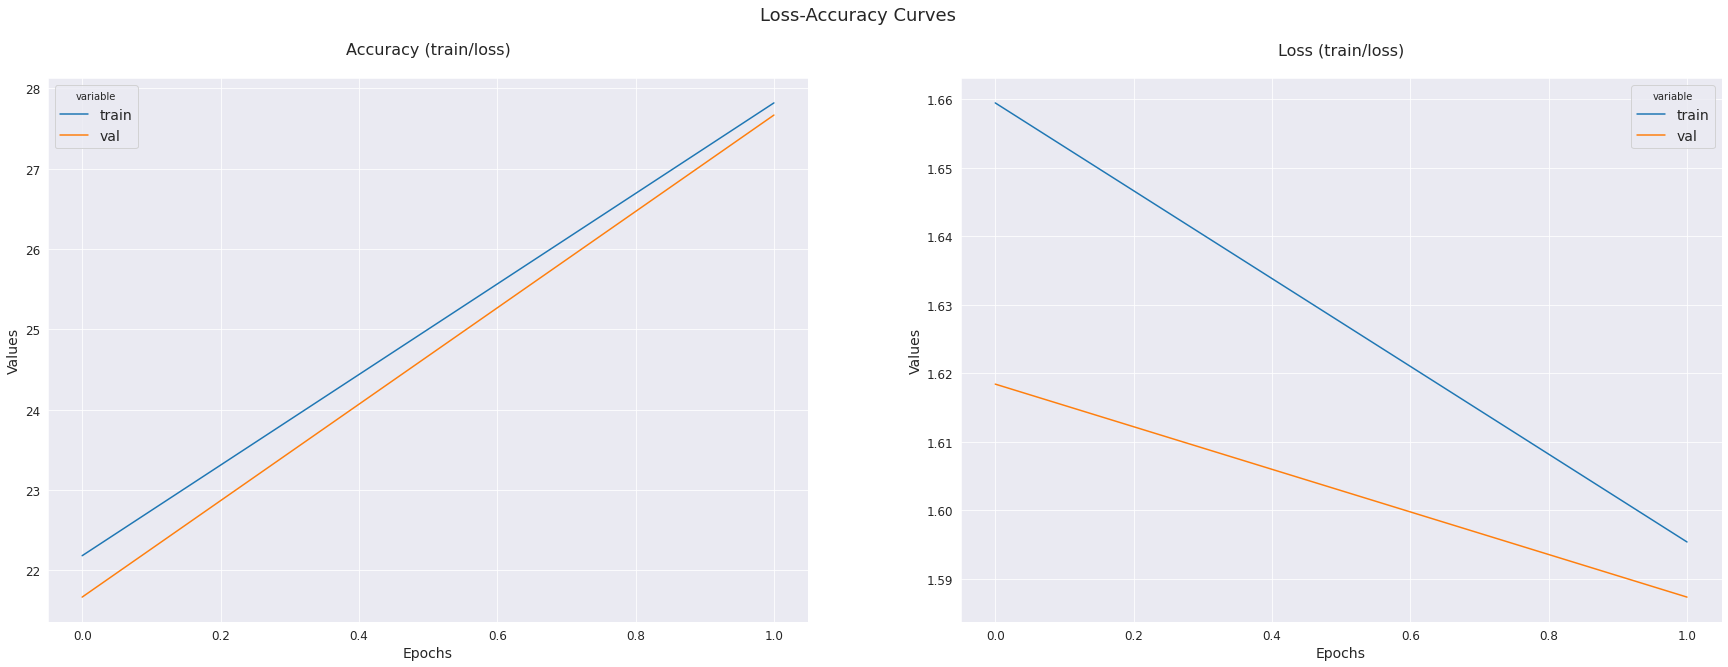

In [14]:
plot_loss_acc_curves(loss_stats, acc_stats)

## Test Model

In [15]:
y_true_list, y_pred_list = test_model(model, test_loader, device)

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.56      0.56        54
           1       0.44      0.30      0.36        50
           2       0.11      0.50      0.18         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10

    accuracy                           0.39       119
   macro avg       0.22      0.27      0.22       119
weighted avg       0.45      0.39      0.41       119






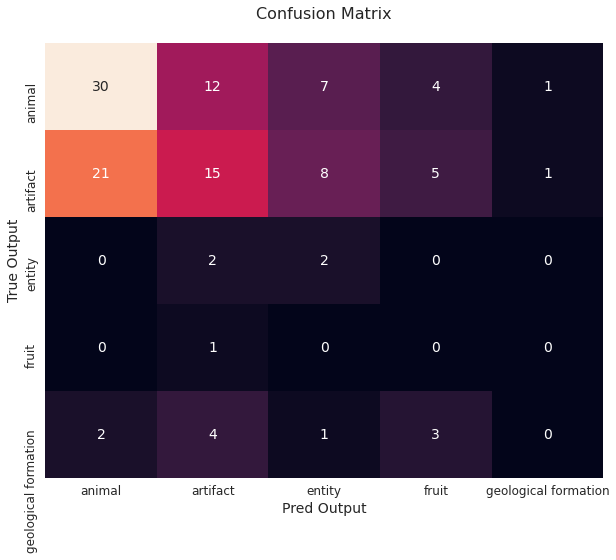

In [16]:
generate_score_report(y_true=y_true_list, y_pred=y_pred_list, idx2class=idx2class)